In [1]:
from ogb.nodeproppred import PygNodePropPredDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.serialization import add_safe_globals
from torch_geometric.data import Data, Batch
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch_geometric.data.storage import GlobalStorage, NodeStorage, EdgeStorage
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# allowlist required torch_geometric classes for safe unpickling
add_safe_globals([DataEdgeAttr, DataTensorAttr, GlobalStorage, NodeStorage, EdgeStorage, Data, Batch])

In [3]:
# Load dataset
dataset = PygNodePropPredDataset(name="ogbn-products", root="data")
data = dataset[0]

In [4]:
print("Original dataset:")
print(f"Nodes: {data.x.shape[0]}")
print(f"Features: {data.x.shape[1]}")
print(f"Edges: {data.edge_index.shape[1]}")
print(f"Labels shape: {data.y.shape}")

Original dataset:
Nodes: 2449029
Features: 100
Edges: 123718280
Labels shape: torch.Size([2449029, 1])


## Subsample for Fair GCN Comparison

**CRITICAL:** To fairly compare with GCN, we must use the SAME 500K subsample.

**Why:** GCN notebook uses 500K subsample (GPU memory constraint). For valid comparison, MLP must use identical data.

**Key:** Using seed=42 ensures both models see exactly the same nodes.

In [5]:
# ===== SUBSAMPLE TO 500K NODES (SAME AS GCN!) =====
print("\n" + "="*60)
print("SUBSAMPLING TO 500K NODES (for fair GCN comparison)")
print("="*60)

# CRITICAL: Use same seed as GCN for identical subsample!
np.random.seed(42)
torch.manual_seed(42)

subsample_size = 500000
total_nodes = data.x.shape[0]
sampled_indices = torch.randperm(total_nodes)[:subsample_size]
sampled_indices = sampled_indices.sort()[0]  # Sort for efficiency

print(f"Original dataset: {total_nodes:,} nodes")
print(f"Subsampled to: {len(sampled_indices):,} nodes")
print(f"Subsampling ratio: {100*len(sampled_indices)/total_nodes:.1f}%")
print(f"Random seed: 42 (MUST match GCN!)")

# Create mapping from old indices to new indices
subsample_mapping = {}
for new_idx, old_idx in enumerate(sampled_indices):
    subsample_mapping[old_idx.item()] = new_idx

# Subsample data (MLP doesn't use edges)
data.x = data.x[sampled_indices]
data.y = data.y[sampled_indices]

print(f"\nAfter subsampling:")
print(f"  Nodes: {data.x.shape[0]:,}")
print(f"  Features: {data.x.shape[1]}")
print(f"  Labels: {data.y.shape[0]:,}")
print("\n✅ Subsampling complete!")
print("="*60)
# ===== END SUBSAMPLE SECTION =====


SUBSAMPLING TO 500K NODES (for fair GCN comparison)
Original dataset: 2,449,029 nodes
Subsampled to: 500,000 nodes
Subsampling ratio: 20.4%
Random seed: 42 (MUST match GCN!)

After subsampling:
  Nodes: 500,000
  Features: 100
  Labels: 500,000

✅ Subsampling complete!


In [6]:
# Load custom splits from CSV files
split_dir = "data/ogbn_products/split/sales_ranking/"
train_df = pd.read_csv(split_dir + "train.csv.gz")
valid_df = pd.read_csv(split_dir + "valid.csv.gz")
test_df = pd.read_csv(split_dir + "test.csv.gz")

# Get original split indices
original_train = torch.tensor(train_df.iloc[:, 0].values, dtype=torch.long)
original_valid = torch.tensor(valid_df.iloc[:, 0].values, dtype=torch.long)
original_test = torch.tensor(test_df.iloc[:, 0].values, dtype=torch.long)

print("\nOriginal split sizes (before subsampling):")
print(f"  Train: {len(original_train):,}")
print(f"  Valid: {len(original_valid):,}")
print(f"  Test: {len(original_test):,}")

# Filter splits to only include nodes in our subsample
train_in_sample = torch.isin(original_train, sampled_indices)
valid_in_sample = torch.isin(original_valid, sampled_indices)
test_in_sample = torch.isin(original_test, sampled_indices)

filtered_train_original = original_train[train_in_sample]
filtered_valid_original = original_valid[valid_in_sample]
filtered_test_original = original_test[test_in_sample]

print("\nSplits after subsampling:")
print(f"  Train: {len(filtered_train_original):,}")
print(f"  Valid: {len(filtered_valid_original):,}")
print(f"  Test: {len(filtered_test_original):,}")

# Map original indices to new subsampled indices
split_idx = {
    'train': torch.tensor([subsample_mapping[idx.item()] for idx in filtered_train_original]),
    'valid': torch.tensor([subsample_mapping[idx.item()] for idx in filtered_valid_original]),
    'test': torch.tensor([subsample_mapping[idx.item()] for idx in filtered_test_original])
}

print("\n✅ Splits remapped to subsampled indices")


Original split sizes (before subsampling):
  Train: 196,614
  Valid: 39,322
  Test: 2,213,090

Splits after subsampling:
  Train: 40,255
  Valid: 8,078
  Test: 451,666

✅ Splits remapped to subsampled indices


In [7]:
# Split indices are now ready (filtered to subsample and remapped)

In [8]:
# Step 1: Find all unique labels
unique_labels = torch.unique(data.y).sort()[0]
print(f"\nAll unique labels: {unique_labels.tolist()}")
selected_labels = set(range(16)) - {4}  # {0,1,2,3,5,6,7,8,9,10,11,12,13,14,15}
print(f"Selected labels: {sorted(selected_labels)}")


All unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
Selected labels: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [9]:
# Step 2: Filter nodes by selected labels
label_mask = torch.tensor([label.item() in selected_labels for label in data.y])
filtered_node_indices = torch.where(label_mask)[0]

In [10]:
print(f"\nFiltered nodes with selected labels: {filtered_node_indices.shape[0]}")


Filtered nodes with selected labels: 284290


In [11]:
# Step 3: Filter train/valid/test splits
train_mask = torch.isin(split_idx['train'], filtered_node_indices)
valid_mask = torch.isin(split_idx['valid'], filtered_node_indices)
test_mask = torch.isin(split_idx['test'], filtered_node_indices)

filtered_train_idx = split_idx['train'][train_mask]
filtered_valid_idx = split_idx['valid'][valid_mask]
filtered_test_idx = split_idx['test'][test_mask]

In [12]:
print(f"\nFiltered splits:")
print(f"Train: {filtered_train_idx.shape[0]}")
print(f"Valid: {filtered_valid_idx.shape[0]}")
print(f"Test: {filtered_test_idx.shape[0]}")


Filtered splits:
Train: 25513
Valid: 5152
Test: 253624


In [13]:
# Step 4: Extract features and labels for filtered nodes
X = data.x[filtered_node_indices]
y = data.y[filtered_node_indices].squeeze()

In [14]:
# Remap labels to 0 to num_classes-1
label_map = {orig: new for new, orig in enumerate(sorted(selected_labels))}
y_mapped = torch.tensor([label_map[label.item()] for label in y])

In [15]:
print(f"\nFiltered dataset shape:")
print(f"X: {X.shape}")
print(f"y: {y.shape}")
print(f"Unique labels in filtered set: {torch.unique(y).tolist()}")
print(f"Remapped labels: {torch.unique(y_mapped).tolist()}")


Filtered dataset shape:
X: torch.Size([284290, 100])
y: torch.Size([284290])
Unique labels in filtered set: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Remapped labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [16]:
# Create mapping from original indices to filtered indices
index_mapping = {orig_idx.item(): new_idx for new_idx, orig_idx in enumerate(filtered_node_indices)}

In [17]:
# Map split indices to new filtered indices
train_idx = torch.tensor([index_mapping[idx.item()] for idx in filtered_train_idx])
valid_idx = torch.tensor([index_mapping[idx.item()] for idx in filtered_valid_idx])
test_idx = torch.tensor([index_mapping[idx.item()] for idx in filtered_test_idx])

In [18]:
print(f"\nFiltered dataset shape:")
print(f"X: {X.shape}")
print(f"y: {y.shape}")
print(f"Unique labels in filtered set: {torch.unique(y).tolist()}")
print(f"Remapped labels: {torch.unique(y_mapped).tolist()}")


Filtered dataset shape:
X: torch.Size([284290, 100])
y: torch.Size([284290])
Unique labels in filtered set: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Remapped labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [19]:
# Step 5: Define MLP model (non-graph baseline)
class MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(MLP, self).__init__()
        self.lin1 = nn.Linear(in_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin3(x)
        return x


In [20]:
# Model parameters
num_features = X.shape[1]
num_classes = len(selected_labels)
hidden_channels = 128

In [21]:
print(f"\nMLP Architecture:")
print(f"Input features: {num_features}")
print(f"Hidden channels: {hidden_channels}")
print(f"Output classes: {num_classes}")


MLP Architecture:
Input features: 100
Hidden channels: 128
Output classes: 15


In [22]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(num_features, hidden_channels, num_classes).to(device)
X = X.to(device)
y_mapped = y_mapped.to(device)

In [23]:
print(f"\nUsing device: {device}")


Using device: cuda


In [24]:
# Training function
def train(model, X, y, train_idx, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(X[train_idx])
    loss = F.cross_entropy(out, y[train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()


In [25]:
# Evaluation function (modified to return both acc and loss)
@torch.no_grad()
def evaluate(model, X, y, split_idx):
    model.eval()
    out = model(X[split_idx])
    loss = F.cross_entropy(out, y[split_idx]).item()
    y_pred = out.argmax(dim=-1)
    correct = (y_pred == y[split_idx]).sum()
    acc = correct / split_idx.size(0)
    return acc.item(), loss


In [26]:
# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
epochs = 350

In [27]:
print("\nTraining MLP baseline (ignoring graph structure)...")
print("-" * 60)


best_val_acc = 0
best_test_acc = 0
best_train_acc = 0
best_epoch = 0
start_time = time.time()

# Lists to store metrics for plotting
train_losses = []
val_losses = []
test_losses = []
train_accs = []
val_accs = []
test_accs = []

for epoch in range(1, epochs + 1):
    loss = train(model, X, y_mapped, train_idx, optimizer)
    train_acc, train_loss = evaluate(model, X, y_mapped, train_idx)
    val_acc, val_loss = evaluate(model, X, y_mapped, valid_idx)
    test_acc, test_loss = evaluate(model, X, y_mapped, test_idx)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
        best_train_acc = train_acc
        best_epoch = epoch
        
    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

training_time = time.time() - start_time  

print("-" * 60)
print(f'\nBest validation accuracy: {best_val_acc:.4f}')
print(f'Test accuracy at best validation: {best_test_acc:.4f}')


Training MLP baseline (ignoring graph structure)...
------------------------------------------------------------
Epoch 020, Loss: 2.3434, Train: 0.4442, Val: 0.4379, Test: 0.3878
Epoch 040, Loss: 1.8834, Train: 0.5316, Val: 0.5169, Test: 0.4435
Epoch 060, Loss: 1.6107, Train: 0.5776, Val: 0.5588, Test: 0.4827
Epoch 080, Loss: 1.4744, Train: 0.6191, Val: 0.5992, Test: 0.5267
Epoch 100, Loss: 1.3870, Train: 0.6420, Val: 0.6180, Test: 0.5541
Epoch 120, Loss: 1.3364, Train: 0.6578, Val: 0.6285, Test: 0.5709
Epoch 140, Loss: 1.2931, Train: 0.6683, Val: 0.6417, Test: 0.5820
Epoch 160, Loss: 1.2682, Train: 0.6784, Val: 0.6516, Test: 0.5899
Epoch 180, Loss: 1.2369, Train: 0.6857, Val: 0.6555, Test: 0.5957
Epoch 200, Loss: 1.2065, Train: 0.6915, Val: 0.6621, Test: 0.6014
Epoch 220, Loss: 1.1917, Train: 0.6971, Val: 0.6648, Test: 0.6046
Epoch 240, Loss: 1.1845, Train: 0.7016, Val: 0.6675, Test: 0.6078
Epoch 260, Loss: 1.1602, Train: 0.7079, Val: 0.6693, Test: 0.6107
Epoch 280, Loss: 1.1449, Tra


Training curves saved as 'training_curves.png'


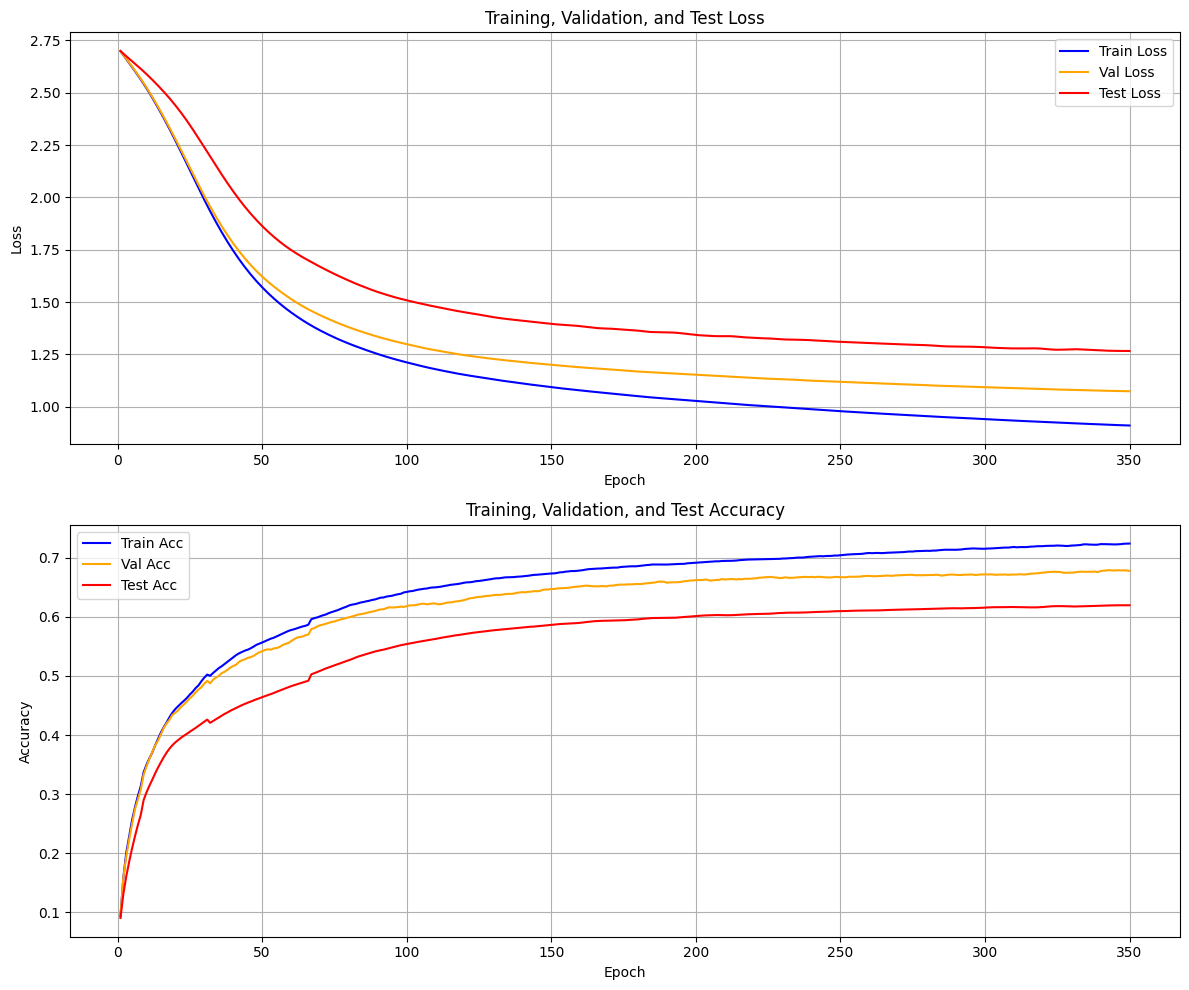

In [28]:
# Plotting training curves
epochs_list = list(range(1, epochs + 1))

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot losses
axes[0].plot(epochs_list, train_losses, label='Train Loss', color='blue')
axes[0].plot(epochs_list, val_losses, label='Val Loss', color='orange')
axes[0].plot(epochs_list, test_losses, label='Test Loss', color='red')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training, Validation, and Test Loss')
axes[0].legend()
axes[0].grid(True)

# Plot accuracies
axes[1].plot(epochs_list, train_accs, label='Train Acc', color='blue')
axes[1].plot(epochs_list, val_accs, label='Val Acc', color='orange')
axes[1].plot(epochs_list, test_accs, label='Test Acc', color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training, Validation, and Test Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('images/MLP/training_curves.png', dpi=300, bbox_inches='tight')
print("\nTraining curves saved as 'training_curves.png'")
plt.show()


Confusion matrix saved as 'confusion_matrix.png'


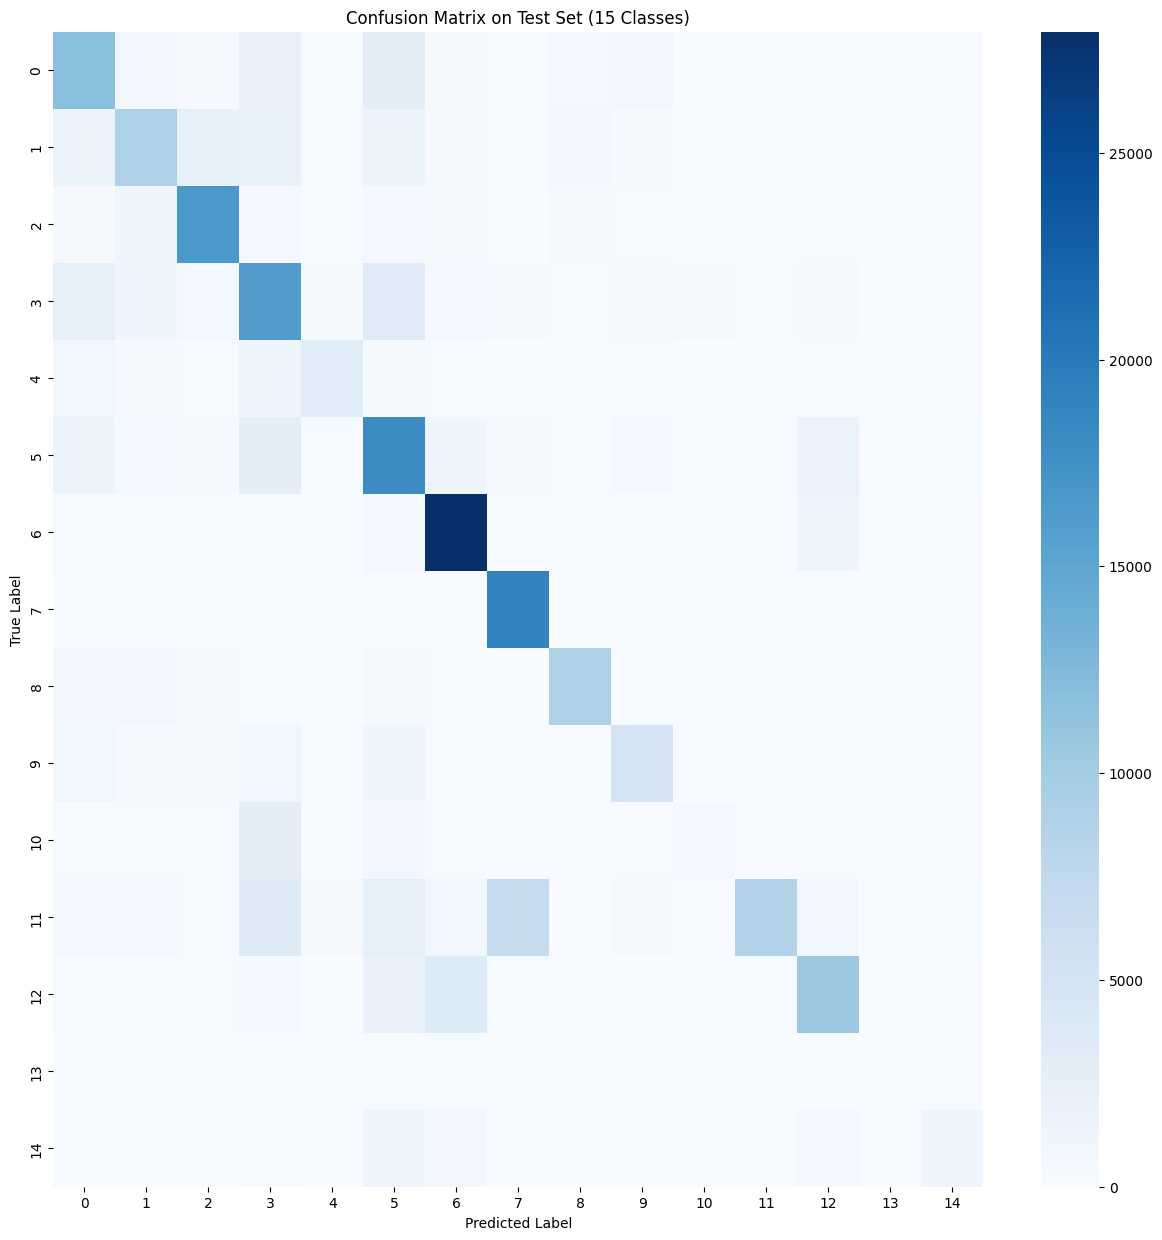

In [29]:
# Compute and plot confusion matrix on test set
torch.no_grad()
model.eval()
out = model(X[test_idx])
y_pred = out.argmax(dim=-1).cpu().numpy()
y_true = y_mapped[test_idx].cpu().numpy()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set (15 Classes)')
plt.savefig('images/MLP/confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\nConfusion matrix saved as 'confusion_matrix.png'")
plt.show()

Top-1 Accuracy: 0.6195
Top-3 Accuracy: 0.8465
Top-5 Accuracy: 0.9214

Top-k accuracy curve saved as 'topk_accuracy_curve.png'


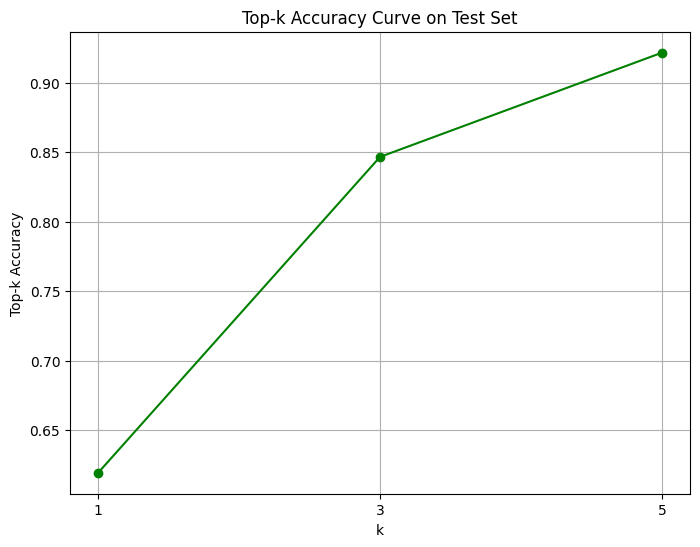

In [30]:
# Compute top-k accuracy for k in {1, 3, 5}
torch.no_grad()
model.eval()
out = model(X[test_idx])
probabilities = F.softmax(out, dim=-1)  # Get probabilities
y_true_tensor = y_mapped[test_idx]

k_values = [1, 3, 5]
topk_accuracies = []

for k in k_values:
    _, topk_indices = torch.topk(probabilities, k, dim=-1)
    correct = 0
    for i in range(len(y_true_tensor)):
        if y_true_tensor[i] in topk_indices[i]:
            correct += 1
    acc = correct / len(y_true_tensor)
    topk_accuracies.append(acc)
    print(f"Top-{k} Accuracy: {acc:.4f}")

# Plot top-k accuracy curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, topk_accuracies, marker='o', linestyle='-', color='green')
plt.xlabel('k')
plt.ylabel('Top-k Accuracy')
plt.title('Top-k Accuracy Curve on Test Set')
plt.xticks(k_values)
plt.grid(True)
plt.savefig('images/MLP/topk_accuracy_curve.png', dpi=300, bbox_inches='tight')
print("\nTop-k accuracy curve saved as 'topk_accuracy_curve.png'")
plt.show()

In [31]:
# Save results to file for easy comparison with GCN
results = {
    'model': 'MLP',
    'subsample_size': 500000,
    'train_accuracy': best_train_acc,
    'test_accuracy': best_test_acc,
    'val_accuracy': best_val_acc,
    'best_epoch': best_epoch,
    'training_time': training_time,
    'num_parameters': sum(p.numel() for p in model.parameters()),
    'top1_acc': topk_accuracies[0],
    'top3_acc': topk_accuracies[1],
    'top5_acc': topk_accuracies[2],
    'hidden_channels': hidden_channels,
    'num_classes': num_classes,
    'num_nodes': X.shape[0],
    'random_seed': 42
}

import json
with open('mlp_500k_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n✅ Results saved to 'mlp_500k_results.json'")
print("\n📁 Generated files:")
print("  - training_curves.png")
print("  - confusion_matrix.png")
print("  - topk_accuracy_curve.png")
print("  - mlp_500k_results.json")
print("\n" + "="*60)
print("MLP BASELINE COMPLETE - Ready to compare with GCN!")
print("="*60)


✅ Results saved to 'mlp_500k_results.json'

📁 Generated files:
  - training_curves.png
  - confusion_matrix.png
  - topk_accuracy_curve.png
  - mlp_500k_results.json

MLP BASELINE COMPLETE - Ready to compare with GCN!
